# Birdsongs.- 11 - Modelando Datos - Deep Learning -  DNN


Mediante este notebook, utilizando redes neuronales densas (DNN), vamos a intentar clasificar un grupo de aves a partir de sus cantos. Los audios han sido convertidos previamente a [periodogramas](https://en.wikipedia.org/wiki/Periodogram), que son representaciones de la señal de audio en el dominio de la frecuencia.

>In signal processing, a periodogram is an estimate of the spectral density of a signal.  The term was coined by Arthur Schuster in 1898.Today, the periodogram is a component of more sophisticated methods (see spectral estimation). It is the most common tool for examining the amplitude vs frequency characteristics of FIR filters and window functions. FFT spectrum analyzers are also implemented as a time-sequence of periodograms. 

El resultado de este notebook es conseguir un modelo lo suficientemente preciso, guardando los parámetros del mejor modelo. Se puede guardar una vez ejecutado como documento HTML para la evaluación conjunta con otros algoritmos o entre diferente set de datos.


## 1.- Librerías

Librerias utilizadas en el notebook


Para el uso de redes neuronales convolucionales utilizaremos Keras sobre Tensorflow
[**keras**](https://keras.io/) 

>Keras is a high-level neural networks API, written in Python and capable of running on top of TensorFlow, CNTK, or Theano. It was developed with a focus on enabling fast experimentation. Being able to go from idea to result with the least possible delay is key to doing good research.

      conda install -c conda-forge keras

Para generar los sets de datos, la matriz de confusión y el informe de clasificación vamos a utilizar sklearn
[**scikit-learn**](https://scikit-learn.org/stable) 

> A set of python modules for machine learning and data mining

      conda install scikit-learn 
      
Para la visualización de datos vamos a utilizar [**seaborn**](https://seaborn.pydata.org/), que es una librería de visualización basada en matplotlib.


      conda install -c anaconda seaborn       

In [1]:
# importar librerías
import os
import numpy as np
import pandas as pd
import sys
import random

from keras import models
from keras import layers
from keras.layers import Dropout
from keras.utils import to_categorical
from keras import optimizers
from keras import losses
from keras import metrics
from keras import regularizers
from keras.callbacks import EarlyStopping

import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


Using TensorFlow backend.


## 2.- Funciones

Funciones comunes utilizadas en el notebook

### Carga especies

Recupera el listado de especies del que consta el dataset

In [2]:
#----------------------------------------------------------------------------
# get_specie_names(path)
#  argumentos: 
#      path: repositorio con los periodogramas
#----------------------------------------------------------------------------
def get_specie_names(path):  
    specie_names = os.listdir(path)
    return specie_names


### Dibuja métrica de entrenamiento

Muestra gráfica del entrenamiento del modelo para una métrica determinada

In [3]:
#----------------------------------------------------------------------------
# plot_metric(history, metric)
#  argumentos: 
#      history: diccionario con la historia del modelo
#      metric: tipo de métrica a representar
#----------------------------------------------------------------------------
def plot_metric(history, metric):
    history_dict = history.history
    values = history_dict[metric]
    
    plt.figure(figsize=(10,6))
    
    if 'val_' + metric in history_dict.keys():  
        val_values = history_dict['val_' + metric]

    epochs = range(1, len(values) + 1)

    if 'val_' + metric in history_dict.keys():  
        plt.plot(epochs, val_values, label='Validation')
    plt.semilogy(epochs, values, label='Training')

    if 'val_' + metric in history_dict.keys():  
        plt.title('Training and validation %s' % metric)
    else:
        plt.title('Training %s' % metric)
        
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.show()      
    

### Dibuja matriz de confusión

Muestra en un gráfico la matriz de confusión

In [4]:
#----------------------------------------------------------------------------
# plot_confusion_matrix(ytest, ypred, target_names)
#  argumentos: 
#      ytest: valores reales
#      ypred: valores predichos
#      target_names: nombre de las clases
#----------------------------------------------------------------------------
def plot_confusion_matrix(ytest, ypred):
    cnf_matrix = confusion_matrix(ytest.argmax(axis=1), ypred.argmax(axis=1))

    plt.figure(figsize=(15,15))

    sns.heatmap(cnf_matrix, square=True, annot=True, fmt='d', cbar=False, 
                xticklabels = l_targets,
                yticklabels = l_targets,
                cmap=plt.cm.Blues)  

    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.show()   


### Dibuja informe de clasificación

Muestra un informe de clasificación con las métricas de precisión, recall, f1-score, ...

In [5]:
#----------------------------------------------------------------------------
# plot_classification_report(ytest, ypred, target_names)
#  argumentos: 
#      ytest: valores reales
#      ypred: valores predichos
#      target_names: nombre de las clases
#----------------------------------------------------------------------------
def plot_classification_report(ytest, ypred, target_names):
    print(classification_report(ytest.argmax(axis=1), ypred.argmax(axis=1),
                                target_names = target_names))  
    

### Contruye el modelo

Crea el modelo secuencial y define las capas que forman parte de él

In [6]:
#----------------------------------------------------------------------------
# build_model()
#----------------------------------------------------------------------------
def build_model():
    dropout_rate = 0.6
        
    # define el modelo
    model = models.Sequential()
    
    # añade capas
    model.add(layers.Dense(128, activation='relu', input_shape=(X.shape[1],)))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    
    model.add(layers.Dropout(dropout_rate))    
    model.add(layers.Dense(len(species), activation=tf.nn.softmax))
    

    # imprime estadísticas
    print(model.summary())

    return model    
    

### Ejecuta el modelo

Ejecuta el modelo

In [7]:
#----------------------------------------------------------------------------
# run_model(Xtrain, ytrain, 
#           Xvalidation, yvalidation, 
#           Xtest, ytest, 
#           epochs_, batch_size_, verbose_):
#  argumentos: 
#           Xtrain: matriz de caraterísticas de train
#           ytrain: etiquetas de train
#           Xvalidation: matriz de caraterísticas de validación
#           yvalidation: etiquetas de validación
#           Xtest: matriz de caraterísticas de test
#           ytest: etiquetas de test
#           epochs_: número de épocas a entrenar
#           batch_size_: tamaño de los batch
#           verbose_ : muestra log de las épocas
#----------------------------------------------------------------------------
def run_model(Xtrain, ytrain, 
              Xvalidation, yvalidation, 
              Xtest, ytest, 
              epochs_, batch_size_, verbose_):
    
    # crea el modelo
    model = build_model()
    
    # compila el modelo
    model.compile(optimizer=optimizers.rmsprop(),
                  loss=losses.categorical_crossentropy,
                  metrics=[metrics.categorical_accuracy])      
    
    # configura callbacks
    callbacks = [EarlyStopping(monitor='val_categorical_accuracy', 
                    patience=20,
                    mode='max',
                    verbose=1),
                ]
    
    
    # entrena el modelo
    history = model.fit(Xtrain, ytrain, epochs=epochs_, batch_size=batch_size_,
                        validation_data=(Xvalidation, yvalidation), 
                        callbacks=callbacks,
                        verbose=verbose_)    

    # dibuja gráfica de la función de pérdida
    plot_metric(history, 'loss')    
    
    # dibuja gráfica de accuracy 
    plot_metric(history, 'categorical_accuracy')    

    # evalua el modelo
    test_loss, test_acc = model.evaluate(Xtest, ytest)
    print(test_loss, test_acc)
    
    # predice contra el set de test
    ypred = model.predict(Xtest)
    
    # genera la matriz de confusión
    plot_confusion_matrix(ytest, ypred)
    
    # imprime informe
    plot_classification_report(ytest, ypred, l_targets)

    
    return test_loss, test_acc, model, history


## 2.- Carga datos

Carga en memoria los datos de los periodogramas desde el repositorio de datos especificado. Es posible seleccionar una muestra de las especies. El resultado es una lista con las grabaciones


In [8]:
# Numpy array de carga de los datos
birds_data = []
birds_target = []

# Diccionario con la información recuperada (especie y número de muestras)
birds_stats = {}

# Repositorio de datos
path = "./data/welch"

# Recupera especies
species = get_specie_names(path)

# Número de especies a tratar
size = 0
if size == 0:
    size = len(species)

# Selecciona especies
species = random.sample(species, size)

# Carga especies
print("Cargando datos...")
for specie in species:
    # ficheros en el directorio
    specie_dir = os.path.join(path, specie) 
    files = os.listdir(specie_dir)

    print("Specie:", specie, "files:", str(len(files)), " " * 20, end='\r', flush=True)
    
    # añade los datos a una lista
    if len(files) > 0:
        for file in files:
            # concatenate numpy array
            specie_path = os.path.join(specie_dir, file)
            data = np.load(specie_path)
           
            birds_data.append(data) 
            birds_target.append(specie)


Cargando datos...


## 2.- Crea Matríz de características y Vector de etiquetas

Prepara los datos para presentárselos al modelo


### Matriz de características

Crea la matriz de caracteristicas, aplicando sobre los datos la raíz cuadrada para hacer más presentables los datos para el modelo

In [9]:
X = np.vstack(birds_data)            
X = np.sqrt(X)


### Vector de Etiquetas

Crea el vector de etiquetas

In [10]:
# vector de etiquetas
y = np.array(birds_target)

# convierte el vector en categórico
df_y = pd.DataFrame(y, columns=['target'])
df_y['code'] =  df_y['target'].astype('category').cat.codes

# crea lista con las especies
df_targets = df_y
df_targets = df_targets.drop_duplicates()
    
print(df_targets.sort_values(by=['code']))
l_targets  = df_targets.sort_values(by=['code'])['target'].values

# vector de etiquetas categorizado
y = np.array(df_y['code'])


                              target  code
7738                Acanthis flammea     0
2357       Acrocephalus arundinaceus     1
9933          Acrocephalus palustris     2
1877      Acrocephalus schoenobaenus     3
10205        Acrocephalus scirpaceus     4
6787              Actitis hypoleucos     5
10627            Aegithalos caudatus     6
2005                 Alauda arvensis     7
1314              Anas platyrhynchos     8
13940               Anthus pratensis     9
13461               Anthus trivialis    10
9476                   Ardea cinerea    11
4084                       Asio otus    12
16829          Caprimulgus europaeus    13
7530             Carduelis carduelis    14
9364           Carpodacus erythrinus    15
9182           Certhia brachydactyla    16
12851             Certhia familiaris    17
468                     Cettia cetti    18
8089                 Chloris chloris    19
12071     Chroicocephalus ridibundus    20
15688             Cisticola juncidis    21
10053  Cocc

## 3.- Define Hiperparámetros

Define los parámetros de entrenamiento del modelo. Para el entrenamiento usaremos k-Fold Cross-Validation

> [k-Fold Cross-Validation](https://machinelearningmastery.com/k-fold-cross-validation/)
> Cross-validation is a resampling procedure used to evaluate machine learning models on a limited data sample.
>Cross-validation is primarily used in applied machine learning to estimate the skill of a machine learning model on unseen data. That is, to use a limited sample in order to estimate how the model is expected to perform in general when used to make predictions on data not used during the training of the model.
>
>It is a popular method because it is simple to understand and because it generally results in a less biased or less optimistic estimate of the model skill than other methods, such as a simple train/test split.


In [11]:
# número de épocas
epochs_ = 100

# tamaño del batch size de entrenamiento
batch_size_=128

# muestra log de épocas por pantalla
verbose_ = 1

# número de grupos en los que dividimos el dataset
n_splits = 4

# semilla para reproducibilidad
seed = 7  


## 4.- Entrena el modelo

Proceso de entrenamiento del modelo, utilizando una estrategia de cross-validation

/home/alberto/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               705792    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 103)               13287     
Total params: 768,615
Trainable params: 768,615
Non-trainable params: 0
_________________________________________________________________
None

10383/10383 [==============================] - 1s 141us/step - loss: 3.2533 - categorical_accuracy: 0.1805 - val_loss: 3.5343 - val_categorical_accuracy: 0.1401
Epoch 42/100
10383/10383 [==============================] - 1s 139us/step - loss: 3.2498 - categorical_accuracy: 0.1768 - val_loss: 3.5160 - val_categorical_accuracy: 0.1600
Epoch 43/100
10383/10383 [==============================] - 1s 140us/step - loss: 3.2329 - categorical_accuracy: 0.1864 - val_loss: 3.5542 - val_categorical_accuracy: 0.1466
Epoch 44/100
10383/10383 [==============================] - 1s 141us/step - loss: 3.2304 - categorical_accuracy: 0.1848 - val_loss: 3.4309 - val_categorical_accuracy: 0.1697
Epoch 45/100
10383/10383 [==============================] - 1s 142us/step - loss: 3.2240 - categorical_accuracy: 0.1841 - val_loss: 3.5505 - val_categorical_accuracy: 0.1457
Epoch 46/100
10383/10383 [==============================] - 1s 141us/step - loss: 3.2065 - categorical_accuracy: 0.1903 - val_loss: 3.6167 - va

10383/10383 [==============================] - 1s 139us/step - loss: 2.8481 - categorical_accuracy: 0.2548 - val_loss: 3.5488 - val_categorical_accuracy: 0.2069
Epoch 89/100
10383/10383 [==============================] - 1s 137us/step - loss: 2.8366 - categorical_accuracy: 0.2533 - val_loss: 3.4554 - val_categorical_accuracy: 0.2055
Epoch 90/100
10383/10383 [==============================] - 1s 137us/step - loss: 2.8328 - categorical_accuracy: 0.2591 - val_loss: 3.4233 - val_categorical_accuracy: 0.2067
Epoch 91/100
10383/10383 [==============================] - 1s 138us/step - loss: 2.8317 - categorical_accuracy: 0.2622 - val_loss: 3.5002 - val_categorical_accuracy: 0.1993
Epoch 92/100
10383/10383 [==============================] - 1s 138us/step - loss: 2.8203 - categorical_accuracy: 0.2585 - val_loss: 3.7349 - val_categorical_accuracy: 0.1970
Epoch 93/100
10383/10383 [==============================] - 1s 133us/step - loss: 2.8029 - categorical_accuracy: 0.2650 - val_loss: 3.5830 - va

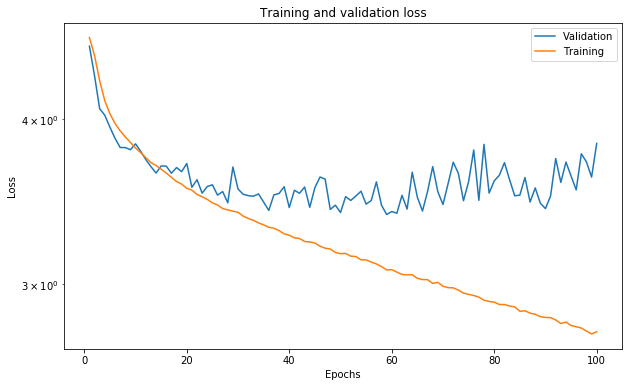

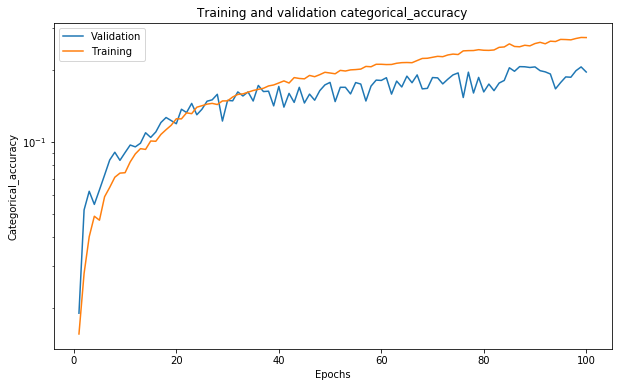

3474/3474 [==============================] - 0s 59us/step
3.76773637921 0.200345423169


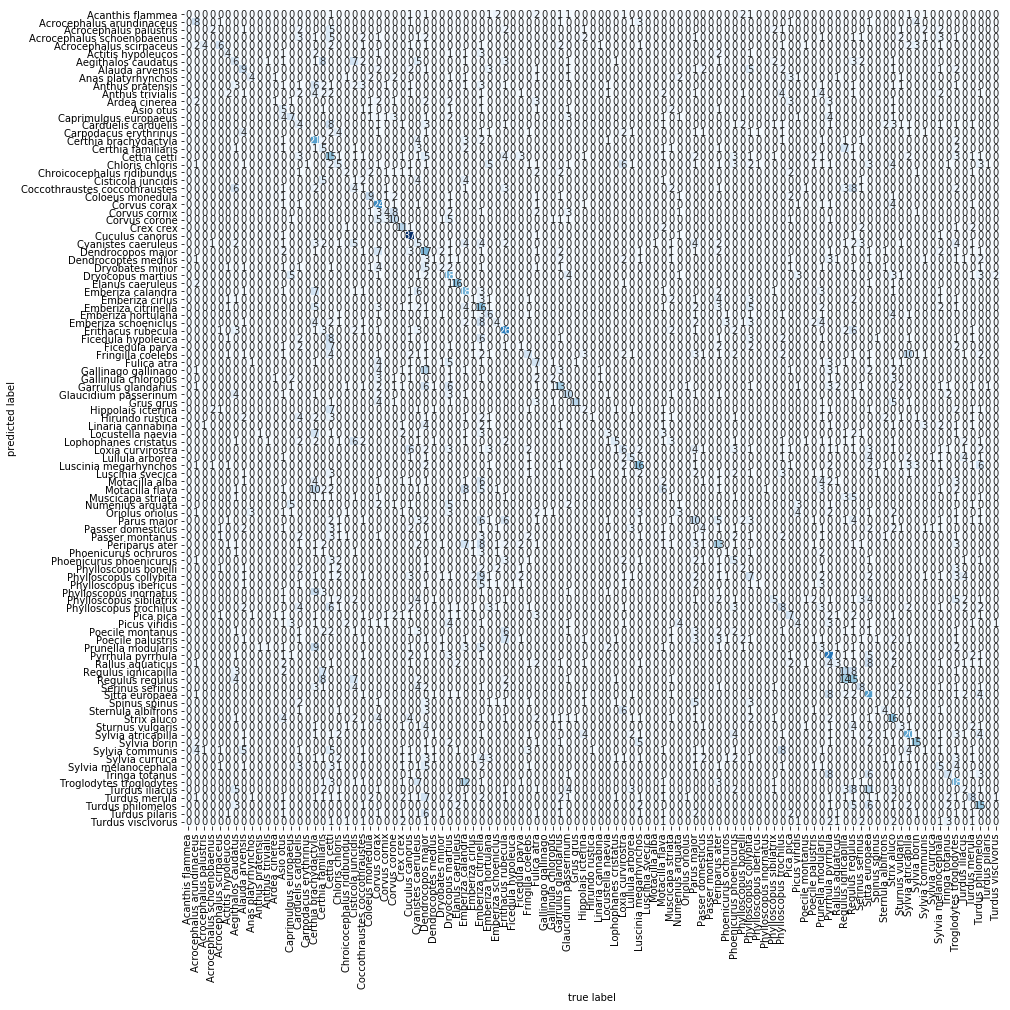

/home/alberto/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/alberto/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/alberto/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                               precision    recall  f1-score   support

             Acanthis flammea       0.00      0.00      0.00        16
    Acrocephalus arundinaceus       0.27      0.38      0.31        21
       Acrocephalus palustris       0.00      0.00      0.00        21
   Acrocephalus schoenobaenus       0.00      0.00      0.00        28
      Acrocephalus scirpaceus       0.40      0.20      0.27        30
           Actitis hypoleucos       0.27      0.25      0.26        16
          Aegithalos caudatus       0.12      0.13      0.13        46
              Alauda arvensis       0.23      0.27      0.25        33
           Anas platyrhynchos       0.40      0.18      0.25        22
             Anthus pratensis       0.00      0.00      0.00        32
             Anthus trivialis       0.00      0.00      0.00        34
                Ardea cinerea       0.25      0.04      0.07        23
                    Asio otus       0.11      0.29      0.16        17
     

Train on 10403 samples, validate on 3493 samples
Epoch 1/100
10403/10403 [==============================] - 1s 132us/step - loss: 4.6049 - categorical_accuracy: 0.0139 - val_loss: 4.5174 - val_categorical_accuracy: 0.0384
Epoch 2/100
10403/10403 [==============================] - 1s 132us/step - loss: 4.4021 - categorical_accuracy: 0.0326 - val_loss: 4.2026 - val_categorical_accuracy: 0.0581
Epoch 3/100
10403/10403 [==============================] - 1s 133us/step - loss: 4.1933 - categorical_accuracy: 0.0387 - val_loss: 4.0519 - val_categorical_accuracy: 0.0601
Epoch 4/100
10403/10403 [==============================] - 1s 132us/step - loss: 4.0839 - categorical_accuracy: 0.0435 - val_loss: 3.9702 - val_categorical_accuracy: 0.0584
Epoch 5/100
10403/10403 [==============================] - 1s 132us/step - loss: 4.0011 - categorical_accuracy: 0.0504 - val_loss: 3.9067 - val_categorical_accuracy: 0.0716
Epoch 6/100
10403/10403 [==============================] - 1s 133us/step - loss: 3.963

Epoch 48/100
10403/10403 [==============================] - 1s 138us/step - loss: 3.1484 - categorical_accuracy: 0.1971 - val_loss: 3.4727 - val_categorical_accuracy: 0.1643
Epoch 49/100
10403/10403 [==============================] - 1s 138us/step - loss: 3.1406 - categorical_accuracy: 0.2003 - val_loss: 3.3623 - val_categorical_accuracy: 0.1809
Epoch 50/100
10403/10403 [==============================] - 1s 138us/step - loss: 3.1349 - categorical_accuracy: 0.2087 - val_loss: 3.3840 - val_categorical_accuracy: 0.1764
Epoch 51/100
10403/10403 [==============================] - 1s 137us/step - loss: 3.1217 - categorical_accuracy: 0.2039 - val_loss: 3.3766 - val_categorical_accuracy: 0.1809
Epoch 52/100
10403/10403 [==============================] - 1s 138us/step - loss: 3.1128 - categorical_accuracy: 0.2088 - val_loss: 3.3418 - val_categorical_accuracy: 0.1895
Epoch 53/100
10403/10403 [==============================] - 1s 138us/step - loss: 3.0904 - categorical_accuracy: 0.2108 - val_loss

10403/10403 [==============================] - 1s 138us/step - loss: 2.7370 - categorical_accuracy: 0.2778 - val_loss: 3.4868 - val_categorical_accuracy: 0.2050
Epoch 96/100
10403/10403 [==============================] - 1s 137us/step - loss: 2.7396 - categorical_accuracy: 0.2770 - val_loss: 3.5940 - val_categorical_accuracy: 0.1784
Epoch 97/100
10403/10403 [==============================] - 1s 137us/step - loss: 2.7437 - categorical_accuracy: 0.2791 - val_loss: 3.7041 - val_categorical_accuracy: 0.1924
Epoch 98/100
10403/10403 [==============================] - 1s 138us/step - loss: 2.7218 - categorical_accuracy: 0.2773 - val_loss: 3.6735 - val_categorical_accuracy: 0.1849
Epoch 99/100
10403/10403 [==============================] - 1s 137us/step - loss: 2.7121 - categorical_accuracy: 0.2825 - val_loss: 3.4595 - val_categorical_accuracy: 0.2021
Epoch 100/100
10403/10403 [==============================] - 1s 138us/step - loss: 2.7128 - categorical_accuracy: 0.2860 - val_loss: 3.6188 - v

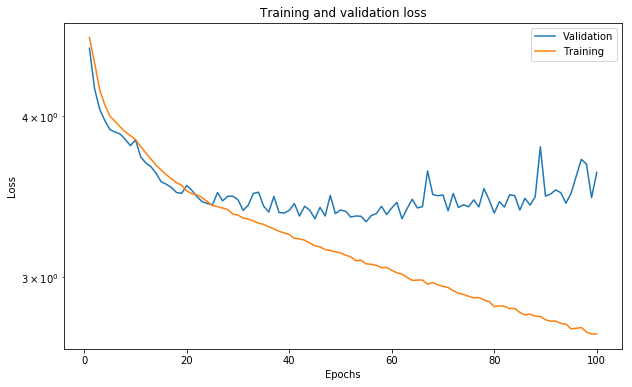

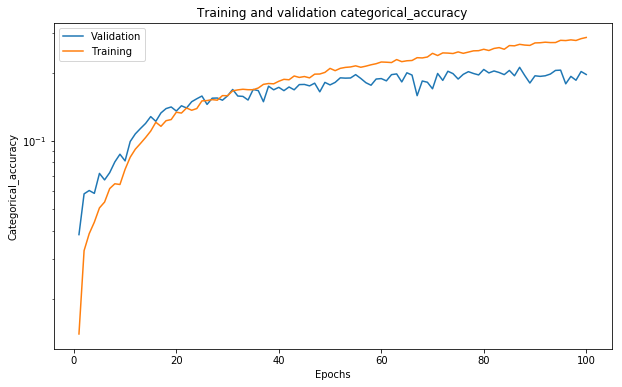

3474/3474 [==============================] - 0s 60us/step
3.56537654582 0.208117443871


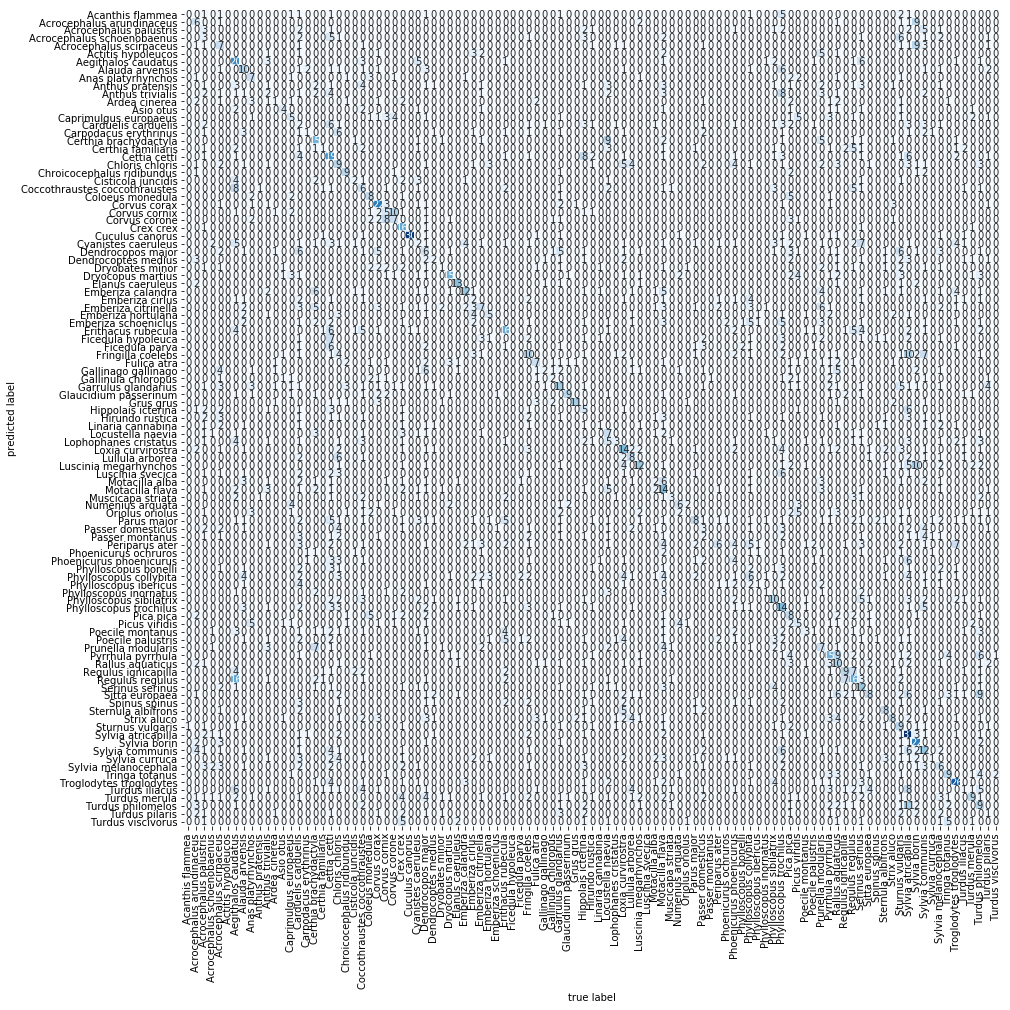

/home/alberto/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/alberto/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/alberto/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                               precision    recall  f1-score   support

             Acanthis flammea       0.00      0.00      0.00        16
    Acrocephalus arundinaceus       0.16      0.29      0.21        21
       Acrocephalus palustris       0.07      0.14      0.09        21
   Acrocephalus schoenobaenus       0.00      0.00      0.00        28
      Acrocephalus scirpaceus       0.14      0.23      0.17        30
           Actitis hypoleucos       0.00      0.00      0.00        16
          Aegithalos caudatus       0.20      0.43      0.28        46
              Alauda arvensis       0.23      0.30      0.26        33
           Anas platyrhynchos       0.23      0.32      0.27        22
             Anthus pratensis       0.00      0.00      0.00        32
             Anthus trivialis       0.07      0.06      0.06        34
                Ardea cinerea       0.12      0.04      0.06        23
                    Asio otus       0.40      0.24      0.30        17
     

Train on 10436 samples, validate on 3460 samples
Epoch 1/100
10436/10436 [==============================] - 1s 140us/step - loss: 4.6026 - categorical_accuracy: 0.0156 - val_loss: 4.5050 - val_categorical_accuracy: 0.0272
Epoch 2/100
10436/10436 [==============================] - 1s 134us/step - loss: 4.3865 - categorical_accuracy: 0.0324 - val_loss: 4.2053 - val_categorical_accuracy: 0.0494
Epoch 3/100
10436/10436 [==============================] - 1s 133us/step - loss: 4.1804 - categorical_accuracy: 0.0443 - val_loss: 4.0376 - val_categorical_accuracy: 0.0671
Epoch 4/100
10436/10436 [==============================] - 1s 132us/step - loss: 4.0681 - categorical_accuracy: 0.0449 - val_loss: 3.9504 - val_categorical_accuracy: 0.0604
Epoch 5/100
10436/10436 [==============================] - 1s 133us/step - loss: 3.9898 - categorical_accuracy: 0.0535 - val_loss: 3.9066 - val_categorical_accuracy: 0.0679
Epoch 6/100
10436/10436 [==============================] - 1s 133us/step - loss: 3.953

Epoch 48/100
10436/10436 [==============================] - 1s 137us/step - loss: 3.1762 - categorical_accuracy: 0.1934 - val_loss: 3.3546 - val_categorical_accuracy: 0.1798
Epoch 49/100
10436/10436 [==============================] - 1s 134us/step - loss: 3.1709 - categorical_accuracy: 0.1909 - val_loss: 3.3974 - val_categorical_accuracy: 0.1792
Epoch 50/100
10436/10436 [==============================] - 1s 143us/step - loss: 3.1641 - categorical_accuracy: 0.1928 - val_loss: 3.3678 - val_categorical_accuracy: 0.1806
Epoch 51/100
10436/10436 [==============================] - 2s 144us/step - loss: 3.1456 - categorical_accuracy: 0.1967 - val_loss: 3.4165 - val_categorical_accuracy: 0.1798
Epoch 52/100
10436/10436 [==============================] - 1s 144us/step - loss: 3.1438 - categorical_accuracy: 0.1972 - val_loss: 3.3608 - val_categorical_accuracy: 0.1876
Epoch 53/100
10436/10436 [==============================] - 1s 144us/step - loss: 3.1191 - categorical_accuracy: 0.2021 - val_loss

10436/10436 [==============================] - 2s 146us/step - loss: 2.7904 - categorical_accuracy: 0.2668 - val_loss: 3.4189 - val_categorical_accuracy: 0.2101
Epoch 96/100
10436/10436 [==============================] - 2s 145us/step - loss: 2.7769 - categorical_accuracy: 0.2704 - val_loss: 3.4971 - val_categorical_accuracy: 0.2124
Epoch 97/100
10436/10436 [==============================] - 2s 145us/step - loss: 2.7694 - categorical_accuracy: 0.2703 - val_loss: 3.5702 - val_categorical_accuracy: 0.2038
Epoch 98/100
10436/10436 [==============================] - 2s 145us/step - loss: 2.7744 - categorical_accuracy: 0.2651 - val_loss: 3.4403 - val_categorical_accuracy: 0.1971
Epoch 99/100
10436/10436 [==============================] - 2s 145us/step - loss: 2.7645 - categorical_accuracy: 0.2722 - val_loss: 3.4035 - val_categorical_accuracy: 0.2150
Epoch 100/100
10436/10436 [==============================] - 2s 145us/step - loss: 2.7522 - categorical_accuracy: 0.2796 - val_loss: 3.5514 - v

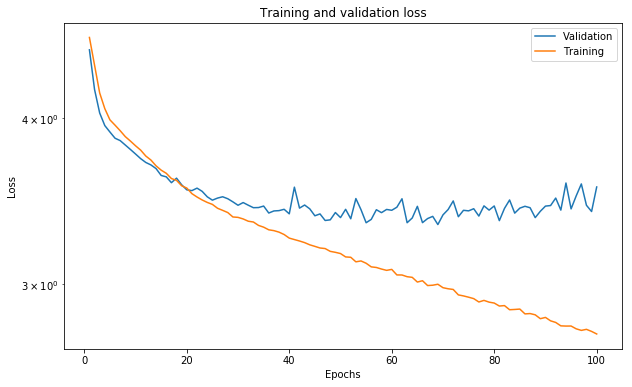

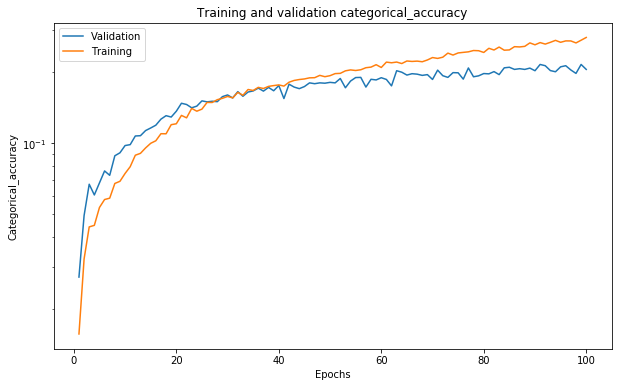

3474/3474 [==============================] - 0s 66us/step
3.53050121921 0.21070811747


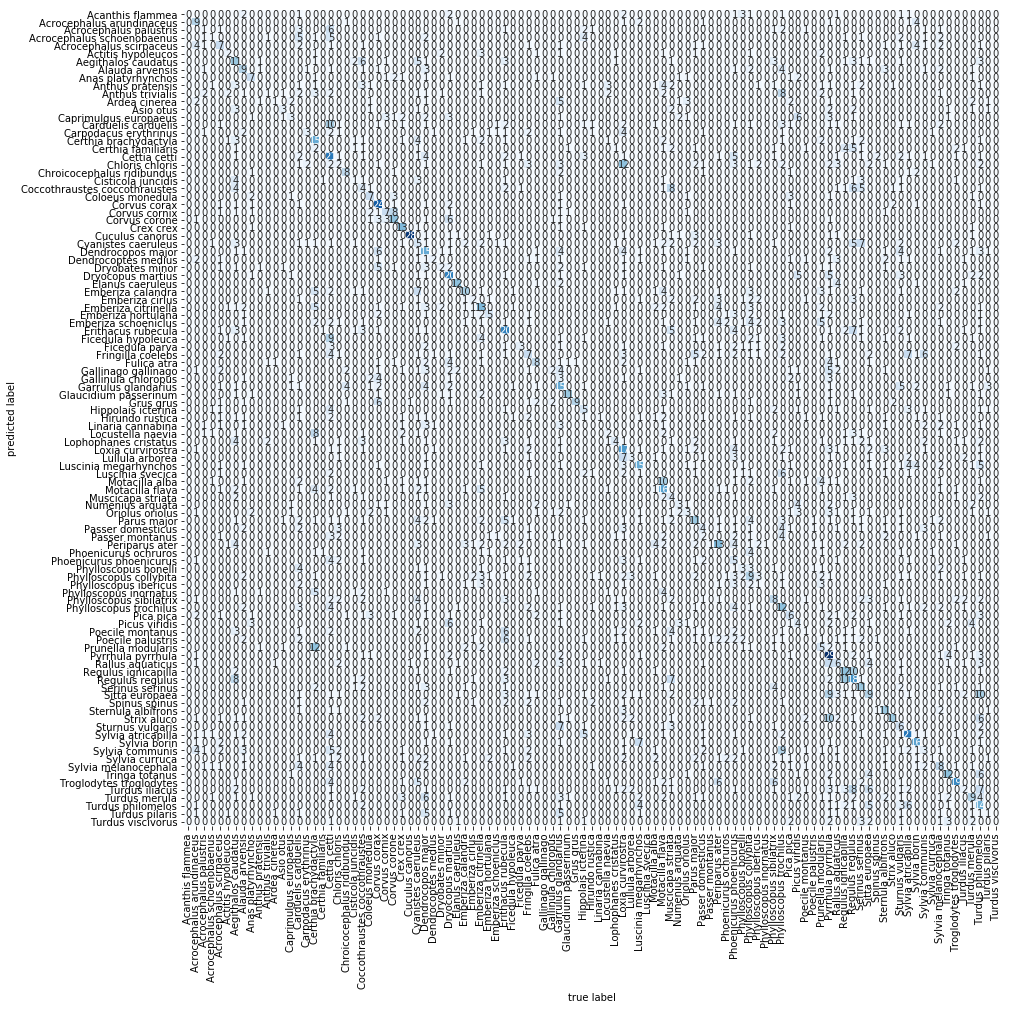

/home/alberto/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/alberto/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/alberto/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                               precision    recall  f1-score   support

             Acanthis flammea       0.00      0.00      0.00        16
    Acrocephalus arundinaceus       0.25      0.43      0.32        21
       Acrocephalus palustris       0.08      0.05      0.06        21
   Acrocephalus schoenobaenus       0.11      0.04      0.05        28
      Acrocephalus scirpaceus       0.21      0.23      0.22        30
           Actitis hypoleucos       0.22      0.12      0.16        16
          Aegithalos caudatus       0.14      0.24      0.18        46
              Alauda arvensis       0.20      0.27      0.23        33
           Anas platyrhynchos       0.30      0.32      0.31        22
             Anthus pratensis       0.00      0.00      0.00        32
             Anthus trivialis       0.14      0.03      0.05        34
                Ardea cinerea       0.25      0.04      0.07        23
                    Asio otus       0.33      0.18      0.23        17
     

Train on 10466 samples, validate on 3430 samples
Epoch 1/100
10466/10466 [==============================] - 2s 148us/step - loss: 4.6111 - categorical_accuracy: 0.0131 - val_loss: 4.5358 - val_categorical_accuracy: 0.0230
Epoch 2/100
10466/10466 [==============================] - 1s 138us/step - loss: 4.4310 - categorical_accuracy: 0.0309 - val_loss: 4.2244 - val_categorical_accuracy: 0.0469
Epoch 3/100
10466/10466 [==============================] - 2s 143us/step - loss: 4.2120 - categorical_accuracy: 0.0447 - val_loss: 4.0348 - val_categorical_accuracy: 0.0566
Epoch 4/100
10466/10466 [==============================] - 2s 144us/step - loss: 4.0913 - categorical_accuracy: 0.0473 - val_loss: 3.9532 - val_categorical_accuracy: 0.0668
Epoch 5/100
10466/10466 [==============================] - 2s 144us/step - loss: 4.0190 - categorical_accuracy: 0.0545 - val_loss: 3.9135 - val_categorical_accuracy: 0.0621
Epoch 6/100
10466/10466 [==============================] - 2s 143us/step - loss: 3.971

Epoch 48/100
10466/10466 [==============================] - 1s 133us/step - loss: 3.1203 - categorical_accuracy: 0.2092 - val_loss: 3.3157 - val_categorical_accuracy: 0.1813
Epoch 49/100
10466/10466 [==============================] - 1s 133us/step - loss: 3.1209 - categorical_accuracy: 0.2066 - val_loss: 3.3434 - val_categorical_accuracy: 0.1787
Epoch 50/100
10466/10466 [==============================] - 1s 134us/step - loss: 3.1022 - categorical_accuracy: 0.2109 - val_loss: 3.3214 - val_categorical_accuracy: 0.1834
Epoch 51/100
10466/10466 [==============================] - 1s 135us/step - loss: 3.0948 - categorical_accuracy: 0.2096 - val_loss: 3.3232 - val_categorical_accuracy: 0.1813
Epoch 52/100
10466/10466 [==============================] - 1s 133us/step - loss: 3.0898 - categorical_accuracy: 0.2140 - val_loss: 3.3432 - val_categorical_accuracy: 0.1828
Epoch 53/100
10466/10466 [==============================] - 1s 135us/step - loss: 3.0851 - categorical_accuracy: 0.2138 - val_loss

10466/10466 [==============================] - 1s 140us/step - loss: 2.7175 - categorical_accuracy: 0.2832 - val_loss: 3.3981 - val_categorical_accuracy: 0.1994
Epoch 96/100
10466/10466 [==============================] - 1s 141us/step - loss: 2.7219 - categorical_accuracy: 0.2805 - val_loss: 3.5144 - val_categorical_accuracy: 0.1880
Epoch 97/100
10466/10466 [==============================] - 2s 166us/step - loss: 2.7098 - categorical_accuracy: 0.2831 - val_loss: 3.5109 - val_categorical_accuracy: 0.1904
Epoch 98/100
10466/10466 [==============================] - 2s 151us/step - loss: 2.7047 - categorical_accuracy: 0.2881 - val_loss: 3.4975 - val_categorical_accuracy: 0.2073
Epoch 99/100
10466/10466 [==============================] - 2s 144us/step - loss: 2.6937 - categorical_accuracy: 0.2843 - val_loss: 3.4625 - val_categorical_accuracy: 0.2052
Epoch 100/100
10466/10466 [==============================] - 1s 143us/step - loss: 2.6920 - categorical_accuracy: 0.2956 - val_loss: 3.3801 - v

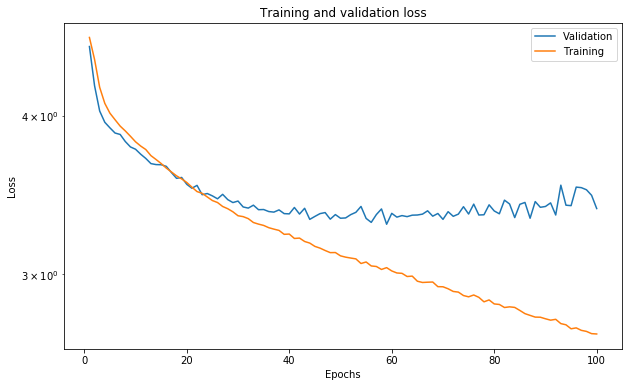

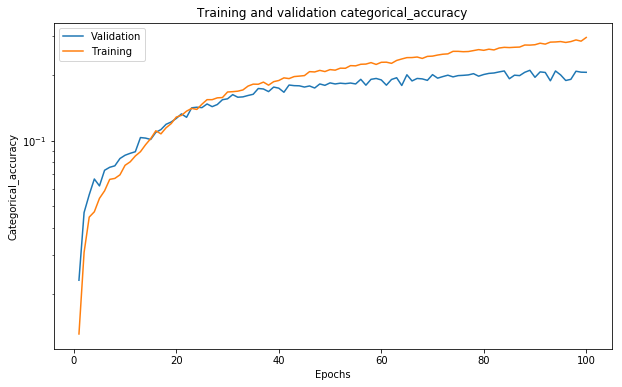

3474/3474 [==============================] - 0s 60us/step
3.36768153349 0.220207253912


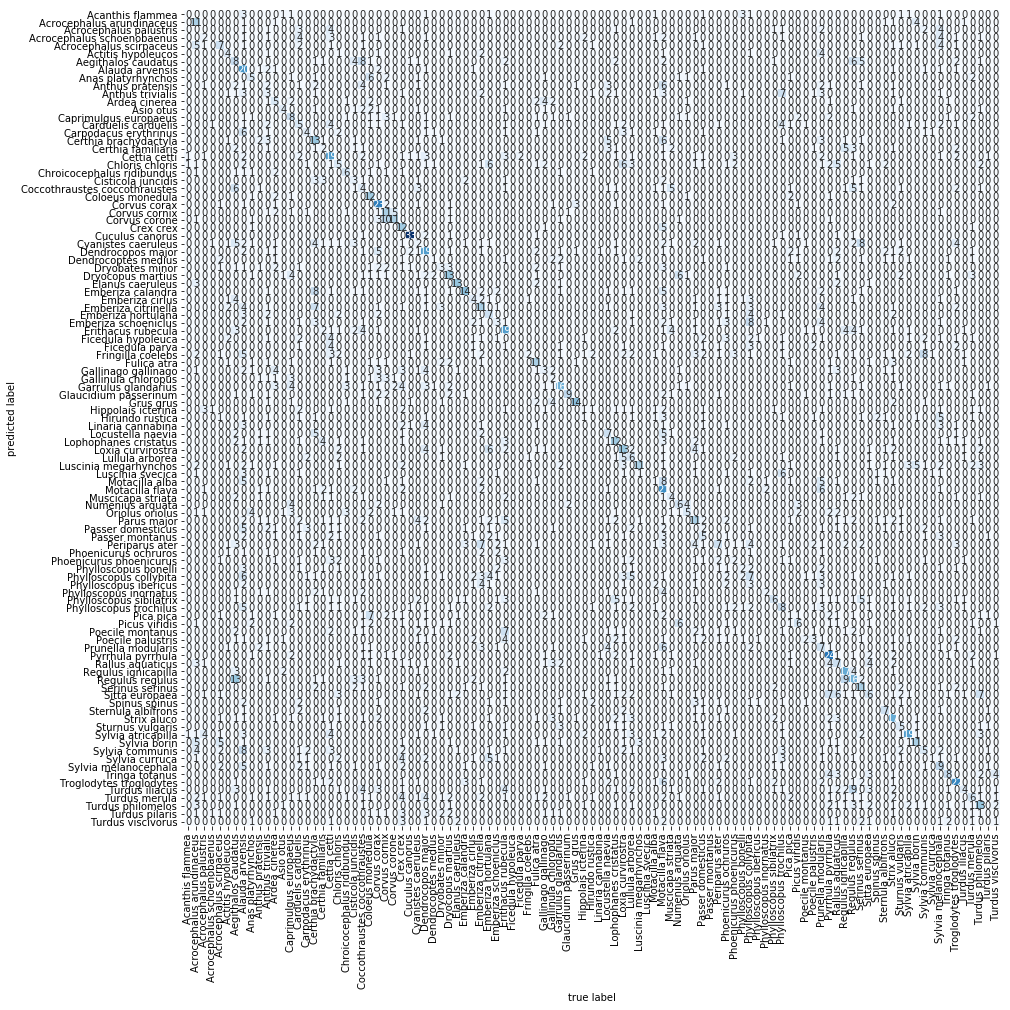

                               precision    recall  f1-score   support

             Acanthis flammea       0.00      0.00      0.00        16
    Acrocephalus arundinaceus       0.22      0.52      0.31        21
       Acrocephalus palustris       0.00      0.00      0.00        21
   Acrocephalus schoenobaenus       0.00      0.00      0.00        28
      Acrocephalus scirpaceus       0.24      0.23      0.24        30
           Actitis hypoleucos       0.24      0.25      0.24        16
          Aegithalos caudatus       0.11      0.17      0.14        46
              Alauda arvensis       0.15      0.61      0.24        33
           Anas platyrhynchos       0.19      0.23      0.21        22
             Anthus pratensis       0.00      0.00      0.00        32
             Anthus trivialis       0.06      0.09      0.07        34
                Ardea cinerea       0.15      0.22      0.18        23
                    Asio otus       0.36      0.24      0.29        17
     

/home/alberto/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/alberto/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/alberto/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [12]:
# Define set de train y test
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=seed, train_size=0.8)   
ytest = to_categorical(ytest)  

# Define n-fold cross validation test 
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

# Guarda los resultados
cvscores = []
    
# Entrena el modelo
for train, validation in kfold.split(Xtrain, ytrain):    
    # Set de train
    X_kfold_train = Xtrain[train]
    y_kfold_train = to_categorical(ytrain[train]) 
    
    # Set de validación
    X_kfold_validation = Xtrain[validation]
    y_kfold_validation = to_categorical(ytrain[validation]) 
        
    # entrena el modelo
    test_loss, test_acc, model, history = run_model(X_kfold_train, y_kfold_train, 
                                                    X_kfold_validation, y_kfold_validation, 
                                                    Xtest, ytest, 
                                                    epochs_, batch_size_, verbose_)   

    # guarda el resultado
    cvscores.append([test_loss, test_acc, model, history])
      


## 5.- Evalua el modelo

Una vez entrenado el modelo, revisamos los resultados del modelo, e iteramos si procede


In [13]:
for e in cvscores:
    print("Test Lost: ", e[0], "Test Accuracy:", e[1])        


Test Lost:  3.76773637921 Test Accuracy: 0.200345423169
Test Lost:  3.56537654582 Test Accuracy: 0.208117443871
Test Lost:  3.53050121921 Test Accuracy: 0.21070811747
Test Lost:  3.36768153349 Test Accuracy: 0.220207253912
